# Tutorial

This is a tutorial for the `momi` package. You can run the ipython notebook that created this tutorial at `examples/tutorial.ipynb`.

To get started, import the `momi` package:

In [1]:
import momi

Some `momi` operations can take awhile complete, so it is useful to turn on status monitoring messages to check that everything is running normally. Here, we output logging messages to the file `tutorial.log`. See the [logging](https://docs.python.org/3/library/logging.html) module for more details.

In [2]:
import logging
logging.basicConfig(level=logging.INFO, filename="tutorial.log")

## Constructing a demographic history

We will construct a demographic model loosely based on human history. To start, we need to specify `N_e`, which is the size of each population unless explicitly specified otherwise, and `gen_time`, the amount of time per generation.

(TODO is `N_e` diploid or haploid???)

We will measure time in years; the human generation time is approximately `gen_time=29` years per generation. The human effective population size is typically measured as $1.2 \times 10^{4}$ so we set `N_e=1.2e4`.

(Note the population size here is NOT the census size, but the population genetics concept of [effective population size](https://en.wikipedia.org/wiki/Effective_population_size) or $N_e$).

In [3]:
model = momi.DemographicModel(N_e=1.2e4, gen_time=29)

We now specify the sampled ("leaf") populations of our demography. We specify three populations: YRI, CHB, and NEA. YRI and CHB are present-day populations at $t=0$, while NEA is an archaic population from $t=50,000$ years ago. We set YRI and NEA to have the default population sizes, and set CHB to have a size of $N=100,000$ growing at rate $.0005$ per year.

TODO check is growth rate g or g/2

In [4]:
# add YRI leaf at t=0 and default_N
model.add_leaf("YRI")
# add  CHB leaf at t=0, N=1e5, growing at rate 5e-4 per unit time (year)
model.add_leaf("CHB", N=1e5, g=5e-4)
# add NEA leaf at 50kya
model.add_leaf("NEA", t=5e4) 

Demographic events are added to the model by the methods `set_size()` and `move_lineages()`. `set_size()` is used to change population size and growth rate, while `move_lineages()` is used for population split and admixture events. 

In [5]:
# stop CHB growth at 10kya
model.set_size("CHB", g=0, t=1e4)

# at 45kya CHB receive a 3% pulse from GhostNea
model.move_lineages("CHB", "GhostNea", t=4.5e4, p=.03)
# at 55kya GhostNea joins onto NEA
model.move_lineages("GhostNea", "NEA", t=5.5e4)

# at 80 kya CHB goes thru bottleneck
model.set_size("CHB", N=100, t=8e4)
# at 85 kya CHB joins onto YRI
model.move_lineages("CHB", "YRI", t=8.5e4)

# at 500 kya YRI joins onto NEA
model.move_lineages("YRI", "NEA", t=5e5)

If you are familiar with the software [ms](http://home.uchicago.edu/rhudson1/source/mksamples.html), `set_size()` is analogous to the flags "-en" and "-eg", while `move_lineages()` is analogous to the flags "-ej" and "-es". If you are familiar with the package [msprime](https://msprime.readthedocs.io/en/stable/), then `set_size()` is analogous to `msprime.PopulationParametersChange`, while `move_lineages()` is analogous to `msprime.MassMigration`.

Note that events can involve other populations aside from the 3 sampled populations YRI, CHB, and NEA. Unsampled populations are also known as "ghost populations". In this example, CHB receives a small amount of admixture from a population "GhostNea", which splits off from NEA at an earlier date.

## Plotting a demography


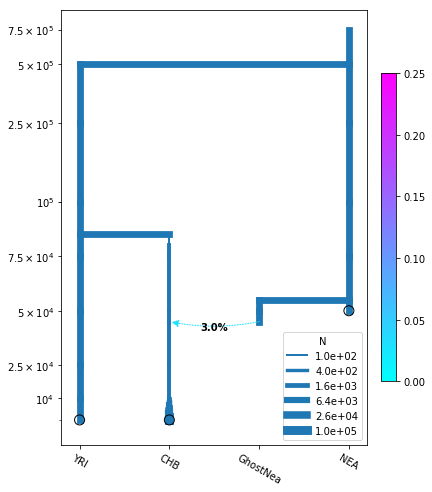

In [6]:
plt = momi.DemographyPlot(model, ["YRI", "CHB", "GhostNea", "NEA"],
                          figsize=(6,8),
                          major_yticks=[1e4, 2.5e4, 5e4, 7.5e4,
                                        1e5, 2.5e5, 5e5, 7.5e5],
                          linthreshy=1e5, pulse_bounds=(0,.25))
plt.draw()

Note the user needs to specify the order of all populations (including ghost populations) along the x-axis.

The argument `linthreshy` is useful for visualizing demographic events at different scales. In our example, the split time of NEA is far above the other events. Times below `linthreshy` are plotted on a linear scale, while times above it are plotted on a log scale.

### Additional plotting details

If you are using Python outside a notebook environment, e.g. in a shell, then you need to call the following before making calls to `draw()`:

```
# call first if in a shell not a notebook:
from matplotlib import pyplot as plt
plt.ion()
```

`momi` uses [matplotlib](https://matplotlib.org/) for plotting. Users can make calls to `matplotlib` to adjust various aspects of the plotting.

TODO simplify the plotting API, make it easier to interact with matplotlib

## Reading and simulating data

In this section we demonstrate how to read in data from a VCF file.

Before we can read in a dataset we first need to create one. So we start by demonstrating how to simulate a VCF from our demography, then we read it in.

### Simulating data 

In [7]:
import os

per_base_mut_rate = 1.25e-8
per_base_recom_rate = 1.25e-8
bases_per_locus = int(5e5)
n_loci = 20
ploidy = 2

# number of alleles to sample per population
sampled_n_dict = {"NEA":2, "YRI":4, "CHB":4}

# create data directory if it doesn't exist
os.makedirs("data", exist_ok=True) 

In [8]:
# simulate 20 "chromosomes", saving each in a separate gzipped vcf file
for chrom in range(n_loci):
      model.simulate_vcf(
          "data/{}.vcf.gz".format(chrom),
          muts_per_gen=per_base_mut_rate,
          recoms_per_gen=per_base_recom_rate,
          length=bases_per_locus,
          chrom_name="chr{}".format(chrom),
          ploidy=ploidy,
          random_seed=1234+chrom,
          sampled_n_dict=sampled_n_dict) 

In [9]:
## read in data from vcf

## first create a dict mapping samples to populations
ind2pop = {}
for pop, n in sampled_n_dict.items():
    for i in range(int(n / ploidy)):
        ## in the simulated vcfs, the samples are named like YRI_0, YRI_1, CHB_0, etc
        ind2pop["{}_{}".format(pop, i)] = pop

# Read in each vcf in a for loop
data = []
for chrom in range(n_loci):
    data.append(momi.SnpAlleleCounts.read_vcf("data/{}.vcf.gz".format(chrom), ind2pop,
                                              ancestral_alleles=True))

# concatenate the 20 loci into a single dataset
data = momi.SnpAlleleCounts.concatenate(data) 

In [10]:
## dump the momi-style data to a gzipped json file
data.dump("data/momi_data.json.gz")

## load the data back from the json file
data2 = momi.SnpAlleleCounts.load("data/momi_data.json.gz")

assert data == data2

In [11]:
## INFERENCE

## create a new model
model2 = momi.DemographicModel(N_e=1.2e4, gen_time=29)

## set the data
model2.set_data(data,
                # use multinomial model, unfolded SFS
                muts_per_gen=None,
                # splits data into 100 equally sized blocks
                # used to compute standard deviation of f4 and other stats
                # via block jackknife
               n_blocks_jackknife=100)

In [12]:
## start by fitting CHB and YRI

## define parameters of the model
#model2.add_size_param("n_chb", 1.2e4)
#model2.add_growth_param("g_chb", 0, lower=-1e-3, upper=1e-3)
#model2.add_time_param("t_chb_yri", 1e5, lower=1e4)
model2.add_size_param("n_chb")
model2.add_growth_param("g_chb", 0, lower=-1e-3, upper=1e-3)
model2.add_time_param("t_chb_yri", lower=1e4)

## add demographic events
model2.add_leaf("CHB", N="n_chb", g="g_chb")
model2.add_leaf("YRI")
model2.set_size("CHB", t=1e4, g=0)
model2.move_lineages("CHB", "YRI", t="t_chb_yri")

In [13]:
#model2.optimize(method="L-BFGS-B")
model2.optimize(method="TNC")

        fun: 0.0012666427909239775
        jac: array([-6.16335608e-06, -7.95269893e-02, -5.05618905e-12])
    message: 'Converged (|f_n-f_(n-1)| ~= 0)'
       nfev: 29
        nit: 10
 parameters: ParamsDict({'n_chb': 38074.79107816558, 'g_chb': 0.0003786073686874582, 't_chb_yri': 114863.59880593774})
     status: 1
    success: True
          x: array([1.05473077e+01, 3.78607369e-04, 1.04863599e+05])

In [14]:
print(model2.get_params())

ParamsDict({'n_chb': 38074.79107816558, 'g_chb': 0.0003786073686874582, 't_chb_yri': 114863.59880593774})


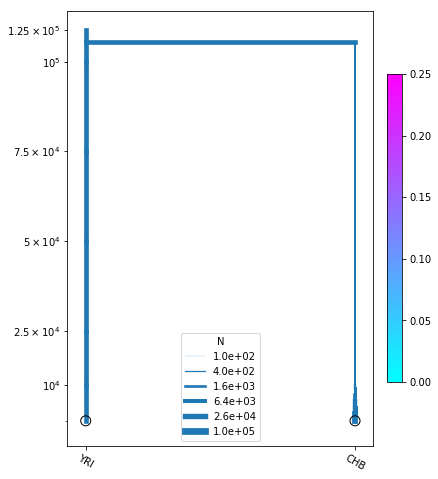

In [15]:
# plot the model
plt = momi.DemographyPlot(model2, ["YRI", "CHB"],
                          figsize=(6,8), linthreshy=1e5,
                          major_yticks=[1e4, 2.5e4, 5e4, 7.5e4,
                          1e5, 1.25e5],
                          pulse_bounds=(0,.25))
plt.draw()

In [16]:
## add NEA to the model

model2.add_leaf("NEA", t=5e4)

#model2.add_time_param("t_anc", 5e5,
#                      lower_constraints=["t_chb_yri"])
model2.add_time_param("t_anc", lower=5e4, lower_constraints=["t_chb_yri"])

model2.move_lineages("YRI", "NEA", t="t_anc")

In [17]:
model2.optimize()

        fun: 0.012457110339958666
        jac: array([-1.14251832e-05,  1.07849599e-01,  4.80191756e-11, -4.02199556e-11])
    message: 'Converged (|f_n-f_(n-1)| ~= 0)'
       nfev: 45
        nit: 12
 parameters: ParamsDict({'n_chb': 1839.746498173358, 'g_chb': 7.232175863039386e-05, 't_chb_yri': 109598.1540227696, 't_anc': 443011.45030157355})
     status: 1
    success: True
          x: array([7.51738307e+00, 7.23217586e-05, 9.95981540e+04, 3.33413296e+05])

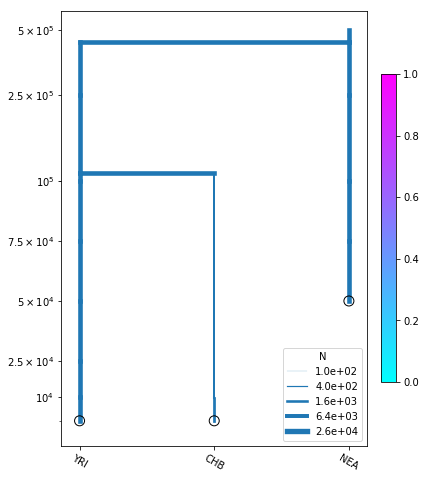

In [18]:
# plot the model
plt = momi.DemographyPlot(model2, ["YRI", "CHB", "NEA"], figsize=(6,8), linthreshy=1e5, major_yticks=[1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5])
plt.draw()

In [19]:
# model diagnostics
fstats = model2.fstats()
# f4(YRI, CHB, NEA, AncestralAllele) < 0 because of unmodeled Neanderthal admixture
# z_score is not significant because we only have a small dataset here
print(fstats.f4("YRI", "CHB", "NEA", None))

# also some functionality to check other statistics
# e.g. f2, f3, distance between every pair of populations
# (TODO: easily plot residuals of all pairwise distances)

ModelFitArray(expected=6.938893903907228e-18, observed=-0.005661024702653249, sd=0.0028238767826156788, z_score=-2.0046996163230624)


In [20]:
## create a new model with added NEA->CHB pulse

add_pulse_model = model2.copy()

#add_pulse_model.add_pulse_param("p_pulse", .1)
#add_pulse_model.add_time_param("t_pulse", 5e4, upper_constraints=["t_chb_yri"])
add_pulse_model.add_pulse_param("p_pulse", upper=.25)
add_pulse_model.add_time_param("t_pulse", upper_constraints=["t_chb_yri"])

add_pulse_model.move_lineages("CHB", "GhostNea", t="t_pulse", p="p_pulse")

#add_pulse_model.add_time_param("t_ghost", 1e5, lower=5e4, lower_constraints=["t_pulse"], upper_constraints=["t_anc"])
add_pulse_model.add_time_param("t_ghost", lower=5e4, lower_constraints=["t_pulse"], upper_constraints=["t_anc"])
add_pulse_model.move_lineages("GhostNea", "NEA", t="t_ghost")

/home/jack/.local/share/virtualenvs/momi2-gAXri9wX/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


In [21]:
# stochastic gradient descent (ADAM+SVRG)
add_pulse_model.stochastic_optimize(snps_per_minibatch=1000, num_iters=10, svrg_epoch=3)

     fun: 3.013547700426011
     jac: array([-2.28024329e-01,  2.21797678e+03,  2.02876203e-06,  2.38050173e-09,
       -7.47063671e-03,  9.85959061e-03,  9.92680927e-04])
 message: 'Maximum number of iterations reached'
     nit: 9
 success: False
       x: array([ 7.44417036e+00, -1.00000000e-03,  9.95983519e+04,  3.33414035e+05,
       -4.38110098e+00,  6.40364802e-01,  4.39655322e-01])

In [23]:
# full gradient descent
add_pulse_model.optimize(method="TNC")

        fun: 0.0043250854075238725
        jac: array([-5.78440560e-06,  1.69838790e-02,  5.25004820e-11, -1.99614356e-11,
        1.05080734e-06, -6.64130271e-07,  1.53665045e-13])
    message: 'Converged (|f_n-f_(n-1)| ~= 0)'
       nfev: 100
        nit: 20
 parameters: ParamsDict({'n_chb': 11209631.710739858, 'g_chb': 0.000999991306483607, 't_chb_yri': 88400.52028870537, 't_anc': 468965.55341052247, 'p_pulse': 0.0674353572159638, 't_pulse': 37071.8118146406, 't_ghost': 50000.00006305978})
     status: 1
    success: True
          x: array([ 1.62322839e+01,  9.99991306e-04,  7.84005203e+04,  3.80565033e+05,
       -2.62676900e+00, -3.25393324e-01, -2.26169714e+01])

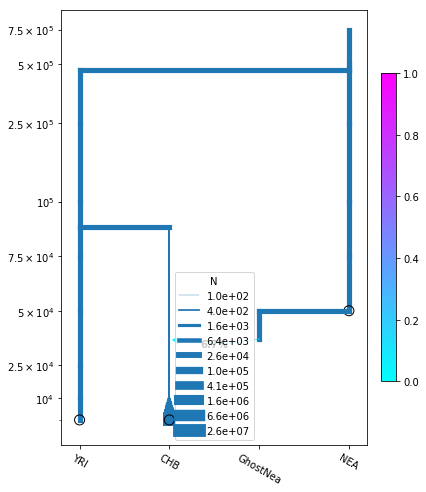

In [24]:
# plot the model
plt = momi.DemographyPlot(add_pulse_model, ["YRI", "CHB", "GhostNea", "NEA"], linthreshy=1e5, figsize=(6,8), major_yticks=[1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5])
plt.draw()

In [33]:
%pdb

Automatic pdb calling has been turned ON


0


/home/jack/.local/share/virtualenvs/momi2-gAXri9wX/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


1


2


3


4


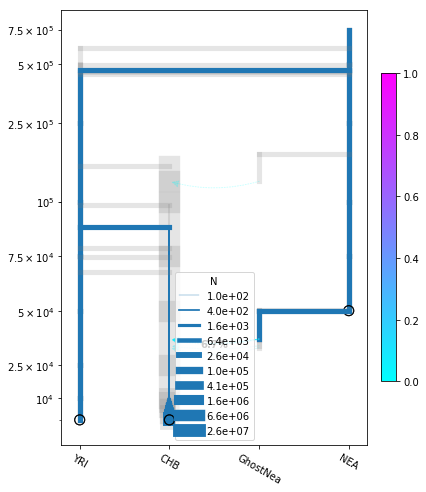

In [25]:
## generate nonparametric bootstrap datasets

n_bootstraps = 5
#n_bootstraps = 20
#bootstrap_mles = []

# split dataset into 100 equally sized blocks to resample
chunked_data = data.chunk_data(100)

plt = momi.DemographyPlot(add_pulse_model, ["YRI", "CHB", "GhostNea", "NEA"], linthreshy=1e5, figsize=(6,8), major_yticks=[1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5])

#bootstrap_model = add_pulse_model.copy()
model2_copy = model2.copy()
add_pulse_copy = add_pulse_model.copy()
for bootstrap_it in range(n_bootstraps):
    print(bootstrap_it)
    # bootstrap resample blocks
    bootstrap_data = chunked_data.resample_chunks()
    model2_copy.set_data(bootstrap_data)
    add_pulse_copy.set_data(bootstrap_data)
    
    model2_copy.set_params(randomize=True)
    model2_copy.optimize()
    add_pulse_copy.set_params(model2_copy.get_params(), randomize=True)
    add_pulse_copy.optimize()

    plt.add_bootstrap(add_pulse_copy.get_params(), alpha=1./n_bootstraps)

plt.draw()


/home/jack/pythonpath/momi/demo_plotter.py:35: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


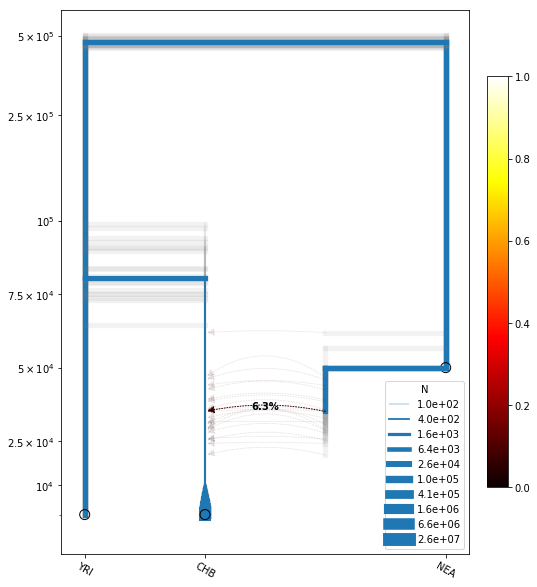

In [ ]:
plt.figure(figsize=(8,10))
add_pulse_model.draw_with_bootstraps(bootstrap_mles,
                                     ["YRI", "CHB", "GhostNea", "NEA"], 
                                     linthreshy=1e5, p_min=0, p_max=1)
plt.gca().set_yticks([1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5])